In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

#my functions
from utils import load_data,my_keras_cv_predict

#go to working directory
work_dir='/mnt/Data1/ribli/mhc/'
os.chdir(work_dir)

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)
/mnt/Data1/ribli/tools/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
x,y=load_data(hla_representation='one-hot',seq_representation='one-hot')

Reading from file...
Creating representation...
Using  83751 data points
Done, It took: 1.9730360508 s


### Create functions for cross validation

In [3]:
#create a very simple deepish model
from keras.models import Sequential
from keras.layers import Dense

def get_model(input_dim):
    """Creates Keras model needed."""
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

#train
y_pred=my_keras_cv_predict(get_model,x,y,n_folds=5,patience=3,verbose=2)

Train on 60300 samples, validate on 6700 samples
Epoch 1/100
2s - loss: 1.4165 - val_loss: 1.2519
Epoch 00000: val_loss improved from inf to 1.25186, saving model to best_model
Epoch 2/100
2s - loss: 0.9282 - val_loss: 0.9163
Epoch 00001: val_loss improved from 1.25186 to 0.91629, saving model to best_model
Epoch 3/100
2s - loss: 0.7060 - val_loss: 0.8533
Epoch 00002: val_loss improved from 0.91629 to 0.85328, saving model to best_model
Epoch 4/100
2s - loss: 0.5811 - val_loss: 0.7615
Epoch 00003: val_loss improved from 0.85328 to 0.76147, saving model to best_model
Epoch 5/100
2s - loss: 0.4913 - val_loss: 0.8484
Epoch 00004: val_loss did not improve
Epoch 6/100
2s - loss: 0.4266 - val_loss: 0.7779
Epoch 00005: val_loss did not improve
Epoch 7/100
2s - loss: 0.3676 - val_loss: 0.7673
Epoch 00006: val_loss did not improve
Epoch 8/100
2s - loss: 0.3177 - val_loss: 0.7983
Epoch 00007: val_loss did not improve
Epoch 00007: early stopping
Train on 60300 samples, validate on 6701 samples
Ep

Correlation: (0.75407558412046638, 0.0)


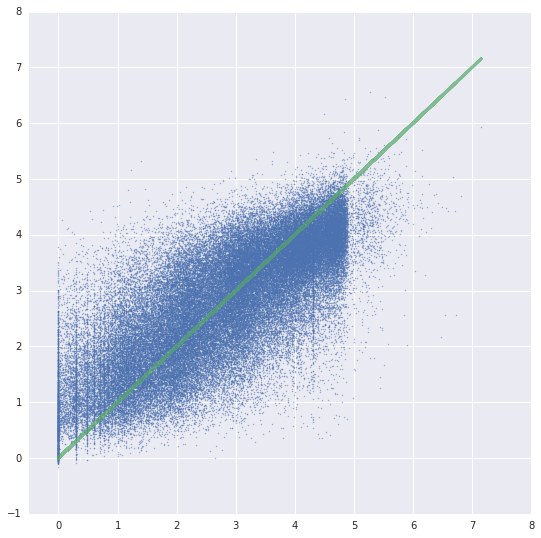

In [4]:
# check correlation
plt.figure(figsize=(9,9))
plt.plot(y,y_pred,'.',ms=3,alpha=0.5)
plt.plot(y,y,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y,y_pred)

### Error depending on the length of peptid

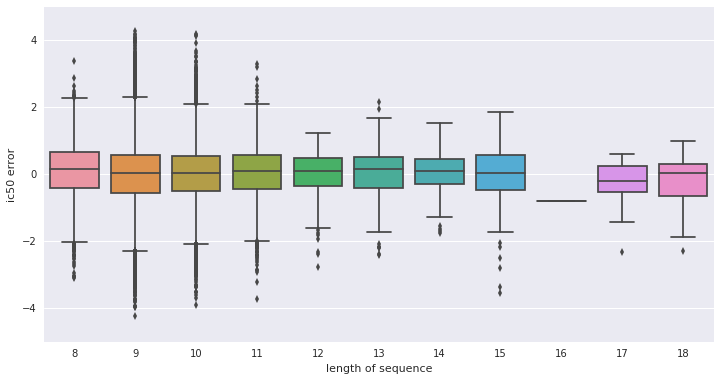

In [5]:
leng=x[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y-y_pred)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')